## Cargando los grafos de prueba

In [140]:
import igraph
import dgl
import torch
import heapq
import time
import progressbar
import pickle
import matplotlib.pyplot as plt
import os

In [122]:
PATH = "data/"
PATH_INSTANCES = "data/ER_graphs/"
FEATURE_TYPE = "1"
input_dim = 32
directed_train = False
use_cuda = False

### Funciones

In [134]:
def get_rev_dgl(graph, feature_type='0', feature_dim=None, is_directed=False, use_cuda=False):
    """get dgl graph from igraph
    """
    
    src, dst = zip(*graph.get_edgelist())

    if use_cuda:
        dglgraph = dgl.graph((dst, src)).to(torch.device("cuda:0"))
    else:
        dglgraph = dgl.graph((dst, src))
        
    if not is_directed:
        dglgraph.add_edges(src, dst)

    if use_cuda:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim).cuda()
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float().cuda()

    else:
        dglgraph.ndata['feat'] = FEATURE_TYPE_DICT[feature_type](graph, feature_dim)
        dglgraph.ndata['degree'] = torch.tensor(graph.degree()).float()
        
    return dglgraph

def gen_one_feature(graph, feature_dim):
    """Generate all-one features
    """
    return torch.ones(graph.vcount(), feature_dim)


FEATURE_TYPE_DICT = {
    "1": gen_one_feature,
}

In [27]:
Graphs = [graph for graph in os.listdir(PATH) if ".txt" in graph]
#"""
MeanNodes = []

N = len(Graphs)

for file in progressbar.progressbar(Graphs):
    graph = igraph.Graph().Read_Edgelist(
        f"{PATH}{file}", directed=False)

    dglgraph = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda = False)
    
    MeanNodes.append(dglgraph.num_nodes())
#"""
print(f"MEAN NODES: {np.mean(MeanNodes):.2f}\nSTD:{np.std(MeanNodes):.2f}\nMAX: {np.max(MeanNodes):.2f}\nMIN: {np.min(MeanNodes):.2f}")

100% (29 of 29) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


MEAN NODES: 44170.41
STD:67189.83
MAX: 317080.00
MIN: 620.00


(array([7., 3., 4., 1., 2., 3., 1., 2., 1., 2.]),
 array([  620. ,  6931.1, 13242.2, 19553.3, 25864.4, 32175.5, 38486.6,
        44797.7, 51108.8, 57419.9, 63731. ]),
 <BarContainer object of 10 artists>)

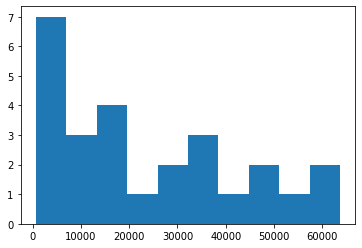

In [38]:
MeanNodes = np.array(MeanNodes)
plt.hist(MeanNodes[MeanNodes < 100_000], bins = 10)

## Convirtiendo dimacs a txt

In [10]:
PATH = "../BRKGA/instances/dimacs/"
NEW_PATH = "../BRKGA/instances/txt/"

In [11]:
Graphs = [graph for graph in os.listdir(PATH)]

In [15]:
Graphs

['Amazon0302.dimacs',
 'Amazon0312.dimacs',
 'Amazon0505.dimacs',
 'Amazon0601.dimacs',
 'com-dblp.ungraph.dimacs',
 'com-youtube.ungraph.dimacs',
 'deezer_HR.dimacs',
 'ego-facebook.dimacs',
 'gemsec_facebook_artist.dimacs',
 'graph_actors_dat.dimacs',
 'graph_CA-AstroPh.dimacs',
 'graph_CA-CondMat.dimacs',
 'graph_CA-GrQc.dimacs',
 'graph_CA-HepPh.dimacs',
 'graph_CA-HepTh.dimacs',
 'graph_dolphins.dimacs',
 'graph_Email-Enron.dimacs',
 'graph_football.dimacs',
 'graph_jazz.dimacs',
 'graph_karate.dimacs',
 'graph_ncstrlwg2.dimacs',
 'loc-gowalla_edges.dimacs',
 'musae_git.dimacs',
 'soc-gplus.dimacs',
 'socfb-Brandeis99.dimacs',
 'socfb-Mich67.dimacs',
 'socfb-nips-ego.dimacs']

In [26]:
def Dimacs2Txt(ruta, nuevaruta):
    file1 = open(ruta, 'r')
    Lines = file1.readlines()
    newname = ".".join((PATH+file).split("/")[-1].split(".")[:-1])+".txt"
    file2 = open(nuevaruta+newname, 'w')
    file1.close()
    for line in Lines[1:]:
        v = line.strip().split()
        file2.write(f"{int(v[1])-1} {int(v[2])-1}")
        file2.write('\n')
    file2.close()
    return newname


In [23]:
for file in progressbar.progressbar(Graphs):
    Dimacs2Txt(PATH+file, NEW_PATH)

100% (27 of 27) |########################| Elapsed Time: 0:00:37 Time:  0:00:37


In [ ]:
# los txt de instances son los de prueba para TSS
# Los utilizados en el FastCava son de puro entrenamiento

In [24]:
5*10**-4

0.0005

In [136]:
import networkx as nx
import matplotlib.pyplot as plt

Cont = 0
NumGrafos = 20
n = 1000
p = 10/n
INSTANCES = []

while True:
    G = nx.erdos_renyi_graph(n, p, directed = False)
    AllConected = True if len([i for i in nx.connected_components(G)]) == 1 else False
    if AllConected:
        INSTANCES.append(G)
        Cont += 1
    if Cont == NumGrafos:
        break
        

In [137]:
for i in range(len(INSTANCES)):
    igraph.Graph().from_networkx(INSTANCES[i]).write_pickle(f"{PATH_INSTANCES}ER_{i}.pkl")

### Recuperando las instancias guardadas

In [127]:
ERInstances = [graph for graph in os.listdir(PATH_INSTANCES)]

In [128]:
graphs = []
dglgraphs = []

for er in progressbar.progressbar(ERInstances):
    graph = igraph.Graph().Read_Pickle(PATH_INSTANCES+er)
    graphs.append(graph)
    
    dgl = get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)
    dglgraphs.append(dgl)

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

AttributeError: 'DGLHeteroGraph' object has no attribute 'graph'

In [132]:
get_rev_dgl(graph, FEATURE_TYPE, input_dim, directed_train, use_cuda)

AttributeError: 'DGLHeteroGraph' object has no attribute 'graph'

In [139]:
f = get_rev_dgl(igraph.Graph().Read_Pickle("nombre.pkl"), FEATURE_TYPE, input_dim, directed_train, use_cuda)

AttributeError: 'DGLHeteroGraph' object has no attribute 'graph'

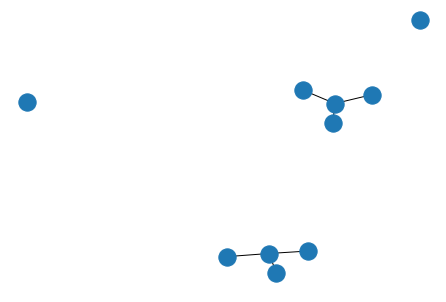

In [118]:
G = nx.erdos_renyi_graph(10, 0.1, directed = False)
nx.draw(G)

In [138]:
ERInstances

['ER_0.pkl',
 'ER_1.pkl',
 'ER_10.pkl',
 'ER_11.pkl',
 'ER_12.pkl',
 'ER_13.pkl',
 'ER_14.pkl',
 'ER_15.pkl',
 'ER_16.pkl',
 'ER_17.pkl',
 'ER_18.pkl',
 'ER_19.pkl',
 'ER_2.pkl',
 'ER_3.pkl',
 'ER_4.pkl',
 'ER_5.pkl',
 'ER_6.pkl',
 'ER_7.pkl',
 'ER_8.pkl',
 'ER_9.pkl']